## Import Dependencies

In [1]:
import numpy as np
import pandas as pd
from sklearn import svm, datasets
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import sklearn.model_selection as model_selection
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.lines import Line2D
import seaborn as sns
from collections import Counter
from scipy import stats
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [2]:
import warnings
warnings.filterwarnings('always') 

## Preprocess Data

#### Import dataset from cleaned file


In [3]:
## replace input_fname with your own dataset
input_fname = "finalClean.csv"
df = pd.read_csv(input_fname)
df = df[["platelet","lsm","risk"]]

#### Remove outlier based on z-score and resample the data

In [4]:
def preprocess(df,zscore,resample_tech,random_state):
    if zscore>0:
        df = df[(np.abs(stats.zscore(df)) < zscore).all(axis=1)]
    X = df[["lsm","platelet"]].to_numpy()
    Y = df['risk'].to_numpy()
    
    if resample_tech == "over":
        ros = RandomOverSampler(random_state=random_state)
        X_res, Y_res = ros.fit_resample(X, Y)
    elif resample_tech == "under":
        rus = RandomUnderSampler(random_state=random_state)
        X_res, Y_res = rus.fit_resample(X, Y)
    else:
        X_res, Y_res = X, Y
    return X_res, Y_res

## Train Model

#### Train the model using given parameters

In [5]:
def train(C,xdata,ydata,xtest,ytest,title, verbose, plot_boundary):
    model = svm.SVC(kernel='linear', C=C,probability=True).fit(xdata, ydata)
    ypred = model.predict(xtest)
    cm = confusion_matrix(ytest,ypred)
    
    # display confusion matrix
    if verbose:
        cm_title = "Confusion Matrix for " + title
        f = sns.heatmap(cm, annot=True, fmt='d')
        f.set_xlabel('Predicted labels')
        f.set_ylabel('True labels');
        f.xaxis.set_ticklabels(['nc', 'c'])
        f.yaxis.set_ticklabels(['nc', 'c']);
        plt.title(cm_title)
        plt.savefig("SVM_CM_Best.png",dpi=300,facecolor='w')
        plt.show()
        print(classification_report(ytest, ypred,digits=3))
    
    # Obtain individual metrics
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]
    TN = cm[0][0]
    FPR = FP/(FP+TN)
    FNR = FN/(TP+FN)
    acc = accuracy_score(ytest, ypred)
    
    # display boundary in scatter graph 
    if plot_boundary:
        # step size in the mesh
        h = .5 

        # create a mesh to plot in
        x_min, x_max = xtest[:, 0].min() - 1, xtest[:, 0].max() + 1
        y_min, y_max = xtest[:, 1].min() - 1, xtest[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))


        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        cmap1 = colors.ListedColormap(['#099e2a','#ff0200'])
        plt.contourf(xx, yy, Z, cmap = cmap1, alpha=0.6)


        cdict = {0: '#099e2a', 1: '#ff0200'}
        for l in np.unique(ytest):
            ix = np.where(ytest == l)
            scatter = plt.scatter(xtest[:,0][ix], xtest[:,1][ix], c = cdict[l], label = l, s = 10)


        legend_elements = [Line2D([0], [0], marker='o', color='#e6e6eb', label='non-cirhotic', markerfacecolor='g', markersize=5),
                           Line2D([0], [0], marker='o', color='#e6e6eb', label='cirrhotic', markerfacecolor='r', markersize=5) ]
        plt.legend(handles=legend_elements, loc='best',facecolor ='w')

        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xlabel('lsm / kPa')
        plt.ylabel('platelet / thousands per microliters of blood')
        plt.xticks()
        plt.yticks()
        plt.title(title)
        plt.savefig("SVM_Boundary_Best.png",dpi=3000,facecolor='w')
        plt.show()

    return model, acc, FPR, FNR

## The Whole Process

#### Preprocess, Split Data and Train model

In [6]:
def svc_train(df,zscore,resample_tech, preprocess_random, train_size,test_size, train_random, C, verbose, plot_boundary):
    x_data, y_data = preprocess(df=df,zscore=zscore,resample_tech=resample_tech,random_state =preprocess_random)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(x_data, y_data, train_size=train_size, 
                                                                    test_size=test_size, random_state=train_random)
    return train(C,X_train,y_train,X_test,y_test,'SVC with linear kernel', verbose, plot_boundary)

#### Loops to Determine Best Model

In [7]:
max_acc = 0
best_model = None
best_stats = [0,0]
best_rand = 0

#Based on testing, best range is between 80-85
for i in range(80,85):
    svc, acc, FPR, FNR = svc_train(df=df,
                                 zscore = 2.5,
                                 resample_tech = "over",
                                 preprocess_random = i,
                                 train_size=0.75,
                                 test_size=0.25,
                                 train_random = i,
                                 C = 1,
                                 verbose = False,
                                 plot_boundary = False)
    if acc>max_acc:
        max_acc = acc
        best_model = svc
        best_stats = [FPR,FNR]
        best_rand = i
print("Chosen model performance:")
print("Acc: %.2f, FPR: %.2f, FNR: %.2f" % (max_acc, best_stats[0],best_stats[1]))
print("Chosen iteration:", best_rand)
print("Equation parameters:", best_model.coef_,best_model.intercept_)

Chosen model performance:
Acc: 0.95, FPR: 0.05, FNR: 0.06
Chosen iteration: 81
Equation parameters: [[ 0.50716783 -0.00404924]] [-3.56141361]


#### Visualise the Result of Final Model

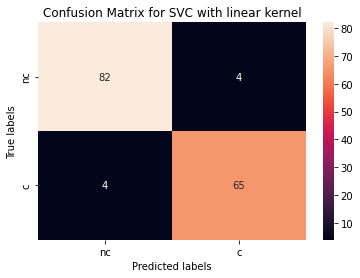

              precision    recall  f1-score   support

           0      0.953     0.953     0.953        86
           1      0.942     0.942     0.942        69

    accuracy                          0.948       155
   macro avg      0.948     0.948     0.948       155
weighted avg      0.948     0.948     0.948       155



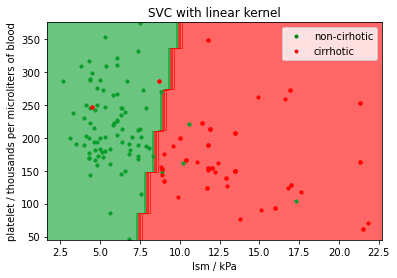

In [8]:
svc, acc, FPR, FNR = svc_train(df=df,
                                 zscore = 2.5,
                                 resample_tech = "over",
                                 preprocess_random = best_rand,
                                 train_size=0.75,
                                 test_size=0.25,
                                 train_random = best_rand,
                                 C = 1,
                                 verbose = True,
                                 plot_boundary = True)

## Tools to Obtain Prediction Result

#### Determine Class using Decision Boundary (0 is non-cirrhotic, 1 is cirrhotic)

In [9]:
def check(model,x,y):
    pos = model.coef_[0][0]*x + model.coef_[0][1]*y + model.intercept_
    if pos<0:
        return 0
    else:
        return 1

In [10]:
check(best_model,8,250)

0

#### Find Distance to the Decision Boundary from Data Point

In [11]:
import math
# x0 is lsm value , y0 is platelet value
def distance(a,b,c,x0,y0):
    result = (a*x0+b*y0+c)/math.sqrt(a*a+b*b)
    return result[0]

In [12]:
distance(best_model.coef_[0][0], best_model.coef_[0][1] , best_model.intercept_, 8,250)

-1.0181350340475275